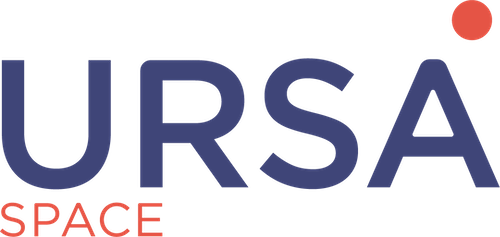

# Global Monitoring Service API

Ursa Space is now removing the borders to a freer and more sensible way of retrieving data for vehicular detections, change detections and object detections. Introducing the Global Monitoring Service (GMS), an easier way to understand vehicular and change detections. GMS is intended to improve upon these previous data sets and offer support for an increased amount of data. In addition, it provides a predictable cost and delivery time frame.

Last updated: July 28th, 2023

In [ ]:
import requests
import os

# API consts
API_DOMAIN = 'https://platform.ursaspace.com'
ENDPOINT_LOGIN = '/api/pas/login'
ENDPOINT_GMSS = '/api/psdm/graphql/gmss'

# Read username/password from environment variables
# For new users looking to sign up, please contact info@ursaspace.com
URSA_USERNAME = os.getenv('URSA_USERNAME')
URSA_PASSWORD = os.getenv('URSA_PASSWORD')

# Login to retrieve JWT
auth_form = {'grant_type': 'password',
             'username': URSA_USERNAME,
             'password': URSA_PASSWORD}
response = requests.post(f'{API_DOMAIN}{ENDPOINT_LOGIN}', data=auth_form)
if response.status_code != 200:
    raise Exception(f"Login failed ({response.status_code}, {response.text})")
    
# JWTs are passed as auth bearer tokens to API requests
jwt = response.json()['access_token']
auth_header = {
    'Authorization': f'Bearer {jwt}'
}

## Basic API Query
Search for results uploaded in the last hour over a particular region. Limit response to 10 results with selected fields returned.

**Note: we recommend GMS users always include at least one region in their query parameters.** Due to data filtering based on user permissions, pages of results may be limited if this field is not included. By including this field with the query parameters, GMS users will always retrieve full pages of results in their responses.

In [ ]:
from datetime import datetime, timedelta
import json

'''
Make a basic request to GMSS

Request body will be in the form:
    {
        ursa_udp_analyticgeojsonrecord(
            QUERY_FIELDS
        )
        {
            RETURN_FIELDS
        }
    }
    
More information can be found at https://info.ursaspace.com/
'''

# Request analytic results uploaded in the last hour
# Limit results to 10 records and ignore GeoJSON features of results for now
query_start_time = datetime.now() - timedelta(hours = 1)
gmss_request = '''
{
    ursa_udp_analyticgeojsonrecord(
        sortBy: { 
            field: "uploadTime", 
            sortOrder: "DESC" 
        }
        limit: 10
        uploadTime: {
            gt: "%s",
        }
        content: { processors: { parameters: { dissemination: { region: { eq: "East Asia" } } } } }
    )
    {
        assignedId
        uploadTime
        content {
            processors {
                processorName
                version
                parameters
            }
        }
    }
}
''' % query_start_time

response = requests.post(f'{API_DOMAIN}{ENDPOINT_GMSS}', headers=auth_header, data=gmss_request)
json_resp = json.loads(response.text)
print(json.dumps(json_resp, indent=2))



## All Available Fields API Query
Retrieve single record and include all available fields in response.

In [ ]:
from datetime import datetime, timedelta
import json

'''
Retrieve a single analytic result with all of its fields

This query shows all of the available fields that can be returned in a GraphQL query
'''
gmss_request = '''
{
    ursa_udp_analyticgeojsonrecord(
        limit: 1
        uploadTime: {
            gt: "2023-02-17T10:33:41.777",
            lt: "2023-02-17T10:33:41.779"
        }
        content: { processors: { parameters: { dissemination: { region: { eq: "Eastern Europe" } } } } }
    )
    {
        assignedId
        uploadTime
        header {
            version
            generatorInfo {
                id
                timeUTC
                generatorType
                generatorVersion
            }
        }
        content {
            type
            product {
                productType
                documentVersion
            }
            processors {
                processorName
                version
                parameters
            }
            sensorData {
                sensorDataIndex
                sensorName
                sensorType
                sensorMode
                productType
                startTimeUTC
                geometryReference
                azimuthAngle
                incidenceAngle
                polarization
                footprint
                vendorId
                ursaId
            }
            features {
                type
                geometry {
                    type
                    coordinates
                }
                properties
            }
        }
    }
}
'''

response = requests.post(f'{API_DOMAIN}{ENDPOINT_GMSS}', headers=auth_header, data=gmss_request)
json_resp = json.loads(response.text)
print(json.dumps(json_resp, indent=2))



## API Query with Pagination
Iterate over pages when limiting results to 5 records per response.

In [ ]:
from datetime import datetime, timedelta
import json

'''
Query results are limited to 5000 records per page. Pages can be iterated over using the 
`offset` input field and the `paginationInfo` field returned in the response.

When the `paginationInfo.nextOffset` field is not present in the response, you are seeing the last page of results.

Limiting results to 5 per page using the `limit` input field for this demo.
'''
base_gmss_request = '''
{
    ursa_udp_analyticgeojsonrecord(
        limit: 5
        offset: %s
        uploadTime: {
            gt: "2023-02-01T00:00:00.000"
        }
        content: { processors: { parameters: { dissemination: { region: { eq: "East Asia" } } } } }
    )
    {
        assignedId
        uploadTime
    }
}
'''

offset = 0
for i in range(5):
    print(f'Querying with offset {offset}')
    gmss_request = base_gmss_request % offset
    response = requests.post(f'{API_DOMAIN}{ENDPOINT_GMSS}', headers=auth_header, data=gmss_request)
    json_resp = json.loads(response.text)
    print('Response:')
    print(json.dumps(json_resp, indent=2))
    
    # The `nextOffset` field will be included in `paginationInfo` if more results are available for this query
    if 'nextOffset' in json_resp['paginationInfo']:
        offset = json_resp['paginationInfo']['nextOffset']


In [ ]:
# We will be using the following geospatial packages in the next cell, verify they are installed
import sys
!{sys.executable} -m pip install geojson geopandas matplotlib
import geojson
import geopandas as gpd

## Specific Analytics API Query
Retrieve results from Vessel Detection and Object Detection analytics in the East Asia and Eastern Europe regions.

In [ ]:
from datetime import datetime, timedelta
import json

'''
Reading GeoJSON from results

Querying for Object Detection and Vessel Detection results in the East Asia region
'''
gmss_request = '''
{
    ursa_udp_analyticgeojsonrecord(
        limit: 5
        content: {
            processors: {
                processorName: {
                    or: ["Object Detection", "Vessel Detection"]
                }
                parameters: {
                    dissemination: {
                        region: {
                            or: ["East Asia", "Eastern Europe"]
                        }
                    }
                }
            }
        }
    )
    {
        assignedId
        uploadTime
        content {
            type
            processors {
                processorName
                parameters
            }
            features {
                type
                geometry {
                    type
                    coordinates
                }
                properties
            }
            
        }
    }
}
'''

response = requests.post(f'{API_DOMAIN}{ENDPOINT_GMSS}', headers=auth_header, data=gmss_request)
json_resp = json.loads(response.text)
print(json.dumps(json_resp, indent=2))


## Read results into GeoJSON
The `content` field of each record contains valid GeoJSON, which can be loaded into GeoJSON libraries.

In [ ]:
# The `content` field of each record contains valid GeoJSON

# Grab the GeoJSON content of the first returned record
json_str = json.dumps(json_resp['data']['ursa_udp_analyticgeojsonrecord'][0]['content'])
geojson_obj = geojson.loads(json_str)
print(f'Valid GeoJSON: {geojson_obj.is_valid}')
print(f'GeoJSON: {geojson.dumps(geojson_obj, indent=2)}')


In [ ]:
# GeoJSON can be loaded as a GeoDataFrame using the geopandas library and plotted
# with geopandas built-in matplotlib support
with open('demo_single-record.geojson', 'w') as f:
    f.write(geojson.dumps(geojson_obj))
    
gdf = gpd.read_file('demo_single-record.geojson')
gdf.plot()
gdf.head()

## Change Detection API Query
Retrieve 10 Change Detection results in Eastern Europe region and load all records into the `geopandas` library.

In [ ]:
from datetime import datetime, timedelta
import json

'''
Querying for Change Detection results in the Eastern Europe taken over a given time range
'''
gmss_request = '''
{
    ursa_udp_analyticgeojsonrecord(
        limit: 10
        content: {
            processors: {
                processorName: {
                    eq: "Change Detection"
                }
                parameters: {
                    dissemination: {
                        region: {
                            eq: "Eastern Europe"
                        }
                    }
                }
            }
            sensorData: {
                startTimeUTC: {
                    gt: "2023-02-01"
                    lt: "2023-03-01"
                }
            }
        }
    )
    {
        assignedId
        uploadTime
        content {
            type
            processors {
                processorName
                parameters
            }
            features {
                type
                geometry {
                    type
                    coordinates
                }
                properties
            }
            sensorData {
                startTimeUTC
            }
        }
    }
}
'''

response = requests.post(f'{API_DOMAIN}{ENDPOINT_GMSS}', headers=auth_header, data=gmss_request)
json_resp = json.loads(response.text)

# Grab the GeoJSON content of every returned record
json_features = { 'type': 'FeatureCollection', 'features': [] }
for record in json_resp['data']['ursa_udp_analyticgeojsonrecord']:
    for feature in record['content']['features']:
        json_features['features'].append(feature)
geojson_obj = geojson.loads(json.dumps(json_features))
print(f'Valid GeoJSON: {geojson_obj.is_valid}')

# GeoJSON can be loaded as a GeoDataFrame using the geopandas library and plotted
# with geopandas built-in matplotlib support
with open('demo_multiple-records.geojson', 'w') as f:
    f.write(geojson.dumps(geojson_obj))
    
gdf = gpd.read_file('demo_multiple-records.geojson')
print(f'Counts:\n{gdf.count()}')
gdf.head()

## Find "Dark Vessels" without AIS Data
Vessel Detection results include associated AIS when available. When no AIS is included with the detected vessel, it implies the ship has turned off its AIS transponder and is not transmitting its location to avoid detection.

In [ ]:
from datetime import datetime, timedelta
import json

'''
Find "Dark Vessels" within Vessel Detection results

Querying for Vessel Detection results in East Asia
'''
gmss_request = '''
{
    ursa_udp_analyticgeojsonrecord(
        limit: 3
        content: {
            processors: {
                processorName: {
                    eq: "Vessel Detection"
                }
                parameters: {
                    dissemination: {
                        region: {
                            eq: "East Asia"
                        }
                    }
                }
            }
        }
        uploadTime: {
            gt: "2023-03-10T00:00:00.000"
            lt: "2023-03-17T00:00:00.000"
        }
    )
    {
        assignedId
        uploadTime
        content {
            type
            processors {
                processorName
                parameters
            }
            features {
                type
                geometry {
                    type
                    coordinates
                }
                properties
            }
            
        }
    }
}
'''

response = requests.post(f'{API_DOMAIN}{ENDPOINT_GMSS}', headers=auth_header, data=gmss_request)
json_resp = json.loads(response.text)
print(json.dumps(json_resp, indent=2))

In [ ]:
from IPython.display import Image, display

# Track all vessel detections that do not have associated AIS data
total_detections = 0
dark_vessels = {}

# Each Vessel Detection analytic result may contain multiple ship detections. Iterate over every analytic result.
for record in json_resp['data']['ursa_udp_analyticgeojsonrecord']:
    # Verify we're looking at vessel detections (in case the above query changes)
    if record['content']['processors'][0]['processorName'] != 'Vessel Detection':
        continue
    
    # Iterate over every detection within the analytic result
    for feature in record['content']['features']:
        total_detections += 1
        
        # Check if detection is missing AIS fields
        if 'aisMmsi' not in feature['properties']:
            # Store detection with its UUID
            dark_vessels[feature['properties']['uuid']] = feature

print(f"Found {len(dark_vessels)} dark vessels out of {total_detections} total detections")
        
for uuid, feature in dark_vessels.items():
    print(f'\nDetection {uuid}:\n{feature}')

## Retrieve Image Chips for Vessel Detections API Query
Retrieve 3 Vessel Detection results in Eastern Europe region, then retrieve each detection's associated SAR image chip.

In [ ]:
from datetime import datetime, timedelta
import json

'''
Retrieve Vessel Detection image chips

Querying for Vessel Detection results
'''
gmss_request = '''
{
    ursa_udp_analyticgeojsonrecord(
        limit: 3
        content: {
            processors: {
                processorName: {
                    eq: "Vessel Detection"
                }
                parameters: {
                    dissemination: {
                        region: {
                            eq: "Eastern Europe"
                        }
                    }
                }
            }
        }
        uploadTime: {
            gt: "2023-02-02T00:00:00.000"
            lt: "2023-02-07T00:00:00.000"
        }
    )
    {
        assignedId
        uploadTime
        content {
            type
            processors {
                processorName
                parameters
            }
            features {
                type
                geometry {
                    type
                    coordinates
                }
                properties
            }
            
        }
    }
}
'''

response = requests.post(f'{API_DOMAIN}{ENDPOINT_GMSS}', headers=auth_header, data=gmss_request)
json_resp = json.loads(response.text)
print(json.dumps(json_resp, indent=2))

In [ ]:
from IPython.display import Image, display

# Track all vessel detection image chips for a given vessel detection analytic
image_chips = {}

# Iterate over every analytic result
for record in json_resp['data']['ursa_udp_analyticgeojsonrecord']:
    
    # Retrieve unique ID assigned to the result record
    assigned_id = record['assignedId']
    region = record['content']['processors'][0]['parameters']['dissemination']['region']
    
    image_chips[(assigned_id, region)] = []
    
    # Retrieve all the image chip IDs
    for feature in record['content']['features']:
        image_chips[(assigned_id, region)].append(feature['properties']['sarChipIdentifier'])

        
# Define a function for generating a URL to retrieve the image chips
base_url = "https://gmss-public-images.s3.amazonaws.com"
def generate_chip_url(region, chip_id):
     return f"{base_url}/{region.replace(' ','-')}/{chip_id}.png"
        
for (assigned_id, region), chips in image_chips.items():
    print(f'Image chips for record {assigned_id}:')
    for chip_id in chips:
        url = generate_chip_url(region, chip_id)
        print(url)
        display(Image(url=url))